# House  Price Prediction
*A complete exploratory data analysis and machine learning project to understand the drivers of real estate prices and build predictive models.*

## 1. Introduction

The housing market generates large amounts of data, and understanding this information is essential for estimating property values and identifying the factors that influence sale prices.
In this project, I analyze a dataset of residential properties and build predictive models to estimate house prices based on their characteristics.

The workflow follows the complete lifecycle of a data science project: inspecting the raw data, identifying quality issues, preparing and transforming features, exploring relevant patterns, and fitting predictive models.

**The main objectives are:**

* Explore how different property features relate to sale price
* Inspect the structure and quality of the dataset
* Clean and prepare the dataset for modeling
* Perform exploratory data analysis (EDA)
* Build and compare predictive models for price estimation
* Evaluate model performance using metrics such as RMSE

This notebook demonstrates how analytical approaches and machine learning techniques can support decision-making in real estate pricing.

## 2. Setup and Data Loading

This section imports all necessary libraries and loads the primary dataset `house_sales.csv` into a Pandas DataFrame for analysis.

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')

file_path_houses = '/content/drive/MyDrive/Colab Notebooks/House Sales/house_sales.csv'
df = pd.read_csv(file_path_houses)

Mounted at /content/drive


## 3. Initial Exploration

Before cleaning the data, we first inspect the structure, feature formats, and potential issues that may require preprocessing.


In [3]:
# First rows to inspect formats and sample values
df.head()

,house_id,city,sale_price,sale_date,months_listed,bedrooms,house_type,area
0,1217792,Silvertown,55943,2021-09-12,5.4,2,Semi-detached,107.8 sq.m.
1,1900913,Silvertown,384677,2021-01-17,6.3,5,Detached,498.8 sq.m.
2,1174927,Riverford,281707,2021-11-10,6.9,6,Detached,542.5 sq.m.
3,1773666,Silvertown,373251,2020-04-13,6.1,6,Det.,528.4 sq.m.
4,1258487,Silvertown,328885,2020-09-24,8.7,5,Detached,477.1 sq.m.


In [4]:
# General information about data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   house_id       1500 non-null   int64  
 1   city           1500 non-null   object 
 2   sale_price     1500 non-null   int64  
 3   sale_date      1500 non-null   object 
 4   months_listed  1469 non-null   float64
 5   bedrooms       1500 non-null   int64  
 6   house_type     1500 non-null   object 
 7   area           1500 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 93.9+ KB


In [5]:
# Summary statistics for numerical features
print(df.describe())

           house_id     sale_price  months_listed     bedrooms
count  1.500000e+03    1500.000000    1469.000000  1500.000000
mean   1.501071e+06  228121.500000       5.901498     4.018000
std    2.835584e+05  117908.147306       1.954070     1.413391
min    1.000296e+06   26348.000000       0.500000     2.000000
25%    1.258978e+06  127470.750000       4.500000     3.000000
50%    1.509208e+06  230058.500000       5.900000     4.000000
75%    1.734578e+06  316793.500000       7.200000     5.000000
max    1.999721e+06  509536.000000      12.300000     6.000000


In [7]:
# Check missing values in 'months_listed'
print(df['months_listed'].isna().sum())

31


In [6]:
# Inspect 'house_type' for inconsistent labels or abbreviations
print(df['house_type'].value_counts(dropna=False))

house_type
Detached         1046
Semi-detached     231
Terraced          123
Det.               78
Semi               14
Terr.               8
Name: count, dtype: int64


In [8]:
# Inspect unusual or placeholder values in 'city'
print(df['city'].value_counts(dropna=False))

city
Silvertown    517
Teasdale      366
Poppleton     362
Riverford     182
--             73
Name: count, dtype: int64


In [9]:
# Check the format of the 'area' column
print(df['area'].head())

0    107.8 sq.m.
1    498.8 sq.m.
2    542.5 sq.m.
3    528.4 sq.m.
4    477.1 sq.m.
Name: area, dtype: object


### Findings from the Initial Exploration

From this first inspection, several preprocessing needs become clear:
* `sale_date` **is stored as string**: must be converted to datetime.
* `months_listed` **contains missing values**: requires imputation.
* `house_type` **includes inconsistent labels** (Det., Semi, Terr.): should be standardized.
* `city` **contains placeholder value "--"**: needs correction.
* `area` i**s stored as text with "sq.m."**: must be cleaned and converted to numeric.
* **Categorical variables are still raw**: will need one-hot encoding for modeling.

These observations guide the cleaning steps in the next section.

## 4. Data Cleaning & Preparation

Based on the issues found during the initial exploration, this section standardizes formats, fixes inconsistent labels, and prepares the dataset for modeling.


In [10]:
# 1. Fix 'sale_date' format
df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')

# 2. Clean 'area': remove the text 'sq.m.' and convert to float
df['area'] = df['area'].str.replace('sq.m.', '', regex=False)
df['area'] = df['area'].astype(float)

# 3. Standardize 'house_type': merge abbreviations with their full versions
mapping_house_type = { 'Det.': 'Detached','Terr.': 'Terraced','Semi': 'Semi-detached'}
df['house_type'] = df['house_type'].replace(mapping_house_type)

# 4. Handle city placeholders (e.g. '--'): replace with 'Unknown'
df['city'] = df['city'].replace('--', 'Unknown')

# 5. Fill missing 'months_listed' using the median (more robust to outliers)
df['months_listed'] = df['months_listed'].fillna(df['months_listed'].median())

# 6. Convert 'sale_price' to float
df['sale_price'] = df['sale_price'].astype(float)

# Final check after cleaning
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   house_id       1500 non-null   int64         
 1   city           1500 non-null   object        
 2   sale_price     1500 non-null   float64       
 3   sale_date      1500 non-null   datetime64[ns]
 4   months_listed  1500 non-null   float64       
 5   bedrooms       1500 non-null   int64         
 6   house_type     1500 non-null   object        
 7   area           1500 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 93.9+ KB


### Why These Steps Matter

* Converting dates and areas ensures proper numerical comparisons.

* Standardizing 'house_type' prevents duplicated categories under different shortcuts.

* Replacing placeholder cities avoids errors during encoding.

* Median imputation avoids distortion from extreme values.

These operations ensure the dataset is consistent and ready for feature analysis and modeling.

## 5. Exploratory Data Analysis (EDA)

EDA helps reveal relationships that may influence property prices.
Here we analyze the target distribution, feature behavior, and correlations.

### 5.1. Distribution of Target Variable (sale_price)

Understanding the distribution of the target variable is essential before selecting and evaluating predictive models.

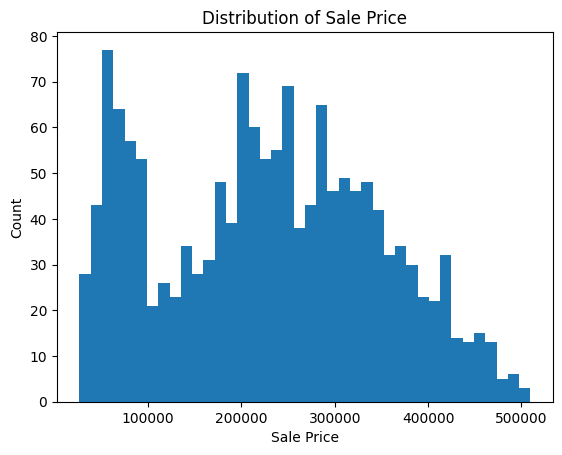

In [11]:
plt.hist(df['sale_price'], bins=40)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.show()

**Observation:**

Real estate prices show a **right-skewed distribution**, which is common in housing markets where a smaller number of properties are much more expensive than the rest.

### 5.2 Bedrooms vs. Sale Price

The number of bedrooms is often believed to be a strong driver of price.
To investigate this, we computed average and variance of sale price per bedroom count.

In [12]:
bedroom_stats = df.groupby('bedrooms')['sale_price'].agg(['mean','var']).reset_index()
bedroom_stats


,bedrooms,mean,var
0,2,67076.357639,5.652896e+08
1,3,154665.105096,2.378289e+09
2,4,234704.630662,1.725211e+09
3,5,301515.885246,2.484328e+09
4,6,375741.313725,3.924432e+09


**Observation:**

Average sale prices increase with the number of bedrooms, although homes with more bedrooms also show higher variability in price.

### 5.3 Correlation Between Numerical Features

We examine how numerical attributes relate to each other and to the target 'sale_price'.

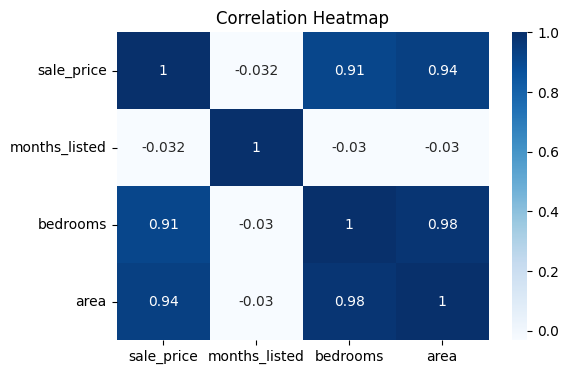

In [13]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['sale_price','months_listed','bedrooms','area']].corr(), annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()

**Observation:**

* Area shows the strongest correlation with sale price.
* Bedrooms also correlate, but less strongly.
* Months listed has minimal correlation.

## 6. Baseline Model: Linear Regression

The goal here is not to get the highest accuracy. This baseline model simply gives us a starting point, so we can later compare and see if more advanced models really improve the results.


### Features Used
For the baseline model, I selected a small but meaningful set of features available early in the workflow:

* 'city'
* 'months listed'
* 'bedrooms'
* 'house type'
* 'area'

The target variable is **'sale_price'**.



In [14]:
X = df[['city', 'months_listed', 'bedrooms', 'house_type', 'area']]
y = df['sale_price']

### Preprocessing Pipeline

To keep the baseline simple and consistent, I applied basic preprocessing:

* **Numeric features**: imputed using the mean

* **Categorical features**: imputed with "Unknown" and one-hot encoded

Even though the dataset was cleaned earlier, the preprocessing pipeline still includes these imputers and encoders, the pipeline guarantees that the model can handle any remaining or future missing values and properly transform categorical features during training and evaluation.


In [15]:
numeric_features = ['months_listed', 'bedrooms', 'area']
numeric_transformer = SimpleImputer(strategy='mean')

categorical_features = ['city', 'house_type']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Fit Baseline Model

In [16]:
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())])

### Train, Predict and RMSE Calculation

In [17]:
# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit model and Predictions
baseline_model.fit(X_train, y_train)
preds = baseline_model.predict(X_test)

# RMSE
rmse_baseline = np.sqrt(mean_squared_error(y_test, preds))
rmse_baseline


np.float64(22077.662770675463)

**Interpretation**

This RMSE value represents the typical prediction error of the baseline Linear Regression model.
In the next section, we will compare this result with a more powerful algorithm (Random Forest) to see if it offers meaningful improvement.

## 7. Comparison Model: Random Forest Regressor

After establishing a baseline with Linear Regression, we now train a Random Forest Regressor, a more flexible and powerful model that can capture non-linear patterns and interactions between features.

Unlike Linear Regression, a Random Forest does not assume linear relationships and tends to perform better in datasets with mixed feature types, irregular distributions, or complex structures.

The goal here is to check whether this more advanced model provides a meaningful improvement over the baseline RMSE.


### Preprocessing & Model Pipeline

We reuse the same features and same preprocessing pipeline defined for the baseline model (numerical pass-through and one-hot encoding for categorical variables) to ensure that both models are compared fairly.

In [18]:
# Random Forest pipeline
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        random_state=42,
        n_estimators=100))])

rf_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['months_listed', 'bedrooms',
                                                   'area']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'house_type'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

### Train, Predict and RMSE Calculation

In [19]:
# Fit and predict Random Forest
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# RMSE
rrmse_rf = np.sqrt(mean_squared_error(y_test, rf_preds))
rrmse_rf

np.float64(17470.928781003433)

**Interpretation:**

If the Random Forest significantly reduces the error, it means:

* Relationships in the data are likely non-linear
* Categorical variables benefit from tree-based handling
* The model is capturing interactions that the baseline could not

If the improvement is modest, it still provides a useful benchmark and shows that the dataset might be relatively straightforward.

## 8. Model Evaluation & Interpretation

After training both models (Linear Regression baseline and Random Forest comparison), we compare their performance using **RMSE (Root Mean Squared Error)**. Lower RMSE means better predictions.

### RMSE Results:

* RMSE Linear Regression:       **22077.66**

* RMSE Random Forest Regressor: **17470.93**

### Interpretation

* The Random Forest clearly reduces prediction error compared with the Linear Regression baseline (about a 5k improvement in RMSE).

* This suggests the Random Forest captures non-linear relationships and interactions (for example, how area interacts with city or house type) that the linear model does not.

* In practice, the **Random Forest is the better choice here** because it gives more accurate and more useful price estimates on this dataset.

## 9. Next Steps & Future Work

There are several ways this project could be expanded to improve both accuracy and real-world value:

* **Feature Engineering**:
create new variables such as price per square meter, days on market, or simplified house type categories to better capture market behavior.

* **Hyperparameter Tuning**:
use GridSearchCV or RandomizedSearchCV to optimize the Random Forest and potentially reduce the RMSE further.

* **Try Additional Models**:
explore models such as Gradient Boosting, XGBoost, or LightGBM, which often perform very well on tabular data.

* **Enhanced Time Features**:
extract year, month, quarter, or season from the sale date to capture market trends or seasonal effects.

* **Outlier Checks**:
investigate extremely high or low sale prices that may distort model learning.

* **Model Explainability**:
Apply SHAP values or feature importance plots to better understand how each feature influences predictions.

These steps keep the project practical and show a clear roadmap for further improvements.

## 10. Conclusion

This notebook walks through a complete, reproducible process for predicting house sale prices:

* we inspected and cleaned real-world data,

* created a simple, interpretable baseline (Linear Regression),

* trained a stronger model (Random Forest), and

* evaluated both models using RMSE.

The Random Forest reduced RMSE from about 22k to 17.5k, showing a meaningful improvement. That model is the current best option for these data, while the suggested next steps outline a clear path to improve results and produce more business-ready insights.